In [1]:
# import scvi
from typing import Dict, Iterable, Optional
# import scvi
import numpy as np
import torch
import pandas as pd
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
# from complementary_models import HALOMASKVIR as HALOVI
# from complementary_models import HALOMASKVAE as HALOVAE

import scanpy as sc
import scvi
from matplotlib import pyplot as plt

Global seed set to 0
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
path2figdir = "figs/Hair/20_aligned"
sc.settings.figdir =path2figdir
sc.set_figure_params(vector_friendly=True)

path = "/mnt/data0/halo/skin/multivelo_hair.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

HALOVI.setup_anndata(adata_mvi,time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
    n_latent=20,
    n_dependent=10
)  

self.w_a :1
yes there is aligner


In [3]:
model = model.load("model_hair_align_causal01_20", adata_mvi)
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()
adata_mvi.obs['latent_time'] = adata_mvi.obs['latent_time'].astype(float)

INFO     File model_hair_align_causal01_20/model.pt already downloaded                       
self.w_a :1
yes there is aligner


/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


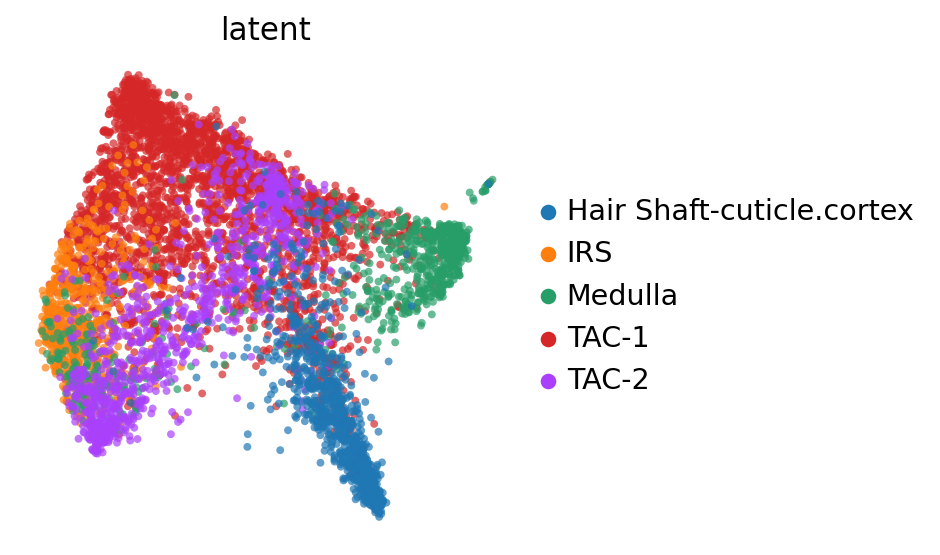

In [4]:
adata_mvi.obsm["latent"] = np.concatenate([latent_expr, latent_acc], axis=1)
sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=10, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1, spread=10)
from matplotlib import pyplot as plt
sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.7, add_outline=False,
        outline_width=(0.1,0), color=['celltype'], title="latent", color_map = 'coolwarm', vmin="p05", vmax="p95") 

In [7]:
## plot chromatin potential of each cell
def compute_chrom_potential_eu(decouple_acc,  couple_acc):
    if decouple_acc.shape != couple_acc.shape:
        raise ValueError("Matrices must have the same shape.")
    
    # Compute the difference couple_acc
    diff_matrix = decouple_acc - couple_acc
    
    # Square the differences
    squared_diff_matrix = np.square(diff_matrix)
    
    # Sum the squares column-wise
    sum_squared_diff = np.sum(squared_diff_matrix, axis=1)
    
    # Square root of the sum gives the Euclidean distance
    distances = np.sqrt(sum_squared_diff)


    min_distance = np.min(distances)
    max_distance = np.max(distances)
    normalized_distances = (distances - min_distance) / (max_distance - min_distance)
    
    
    return normalized_distances


def compute_chrom_potential_cos(matrix1, matrix2):
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same shape.")
    
    dot_product = np.sum(matrix1 * matrix2, axis=1)
    magnitude1 = np.sqrt(np.sum(matrix1**2, axis=1))
    magnitude2 = np.sqrt(np.sum(matrix2**2, axis=1))
    cosine_similarity = dot_product / (magnitude1 * magnitude2)
    cosine_distance = 1 - cosine_similarity
    
    # Normalize the distances
    # min_distance = np.min(cosine_distance)
    # max_distance = np.max(cosine_distance)
    # normalized_distances = (cosine_distance - min_distance) / (max_distance - min_distance)
    
    return cosine_distance
from numpy.linalg import inv 

def residue_potential(matrix1, matrix2, time):
    X = matrix1
    Y = matrix2

    b = inv(X.T.dot(X)).dot(X.T).dot(Y)

    Yhat = X.dot(b)
    Y_Residual = Yhat - Y
    Y_Residual_3 = np.mean(np.abs(Y_Residual),axis=1)

    z = np.polyfit(time, Y_Residual_3, 3)
    p = np.poly1d(z)

    Y_Residual_smooth = p(time)

    return Y_Residual_smooth


def rbf_kernel(x, y, gamma=0.5):
    return np.exp(-gamma * np.linalg.norm(x-y)**2)

def rbf_kernel_inv(x, y, gamma=0.5):
    return np.exp(gamma * np.linalg.norm(x-y)**2)

# Polynomial Kernel Function
def polynomial_kernel(x, y, degree=3, r=1, gamma=1):
    return (gamma * np.dot(x, y) + r) ** degree

# Linear Kernel Function
def linear_kernel(x, y, gamma=1):
    return np.dot(x, y)
def compute_chrom_potential(X, Y, kernel_function=rbf_kernel, gamma=5):
    """
    Compute the kernel similarities between each row of matrix X and each row of matrix Y.
    
    Parameters:
    - X: numpy array of shape (n_samples_X, n_features)
    - Y: numpy array of shape (n_samples_Y, n_features)
    - kernel_function: function to compute the kernel. Default is RBF kernel.
    - gamma: Parameter for the RBF kernel.
    
    Returns:
    - similarities: numpy array of shape (n_samples_X, n_samples_Y) containing the kernel similarities.
    """
    n_samples_X, n_features_X = X.shape
    n_samples_Y, n_features_Y = Y.shape
    assert n_features_X == n_features_Y, "The number of features in X and Y must be the same."
    
    similarities = np.zeros((n_samples_X))
    for i in range(n_samples_X):
            similarities[i] = kernel_function(X[i, :], Y[i, :], gamma=gamma)
    similarities = np.array(similarities)
    min_val = np.min(similarities)
    max_val = np.max(similarities)
    similarities = 1- (similarities - min_val) / (max_val - min_val)        
    return similarities

def smooth_potential_knn(similarity, adata, n=50):
    ncell = adata.shape[0]
    smooth_sim = []
    for i in range(ncell):
        knn_cells = adata_mvi.obsp["connectivities"][i, :].toarray()[0]
        knn_cells = np.argsort(knn_cells)[-n:]
        if n!=1:
            knn_cells = np.append(knn_cells, i)
        else:
            knn_cells= [i]    
        smooth_sim.append(np.mean(similarity[knn_cells]))
    return np.array(smooth_sim)


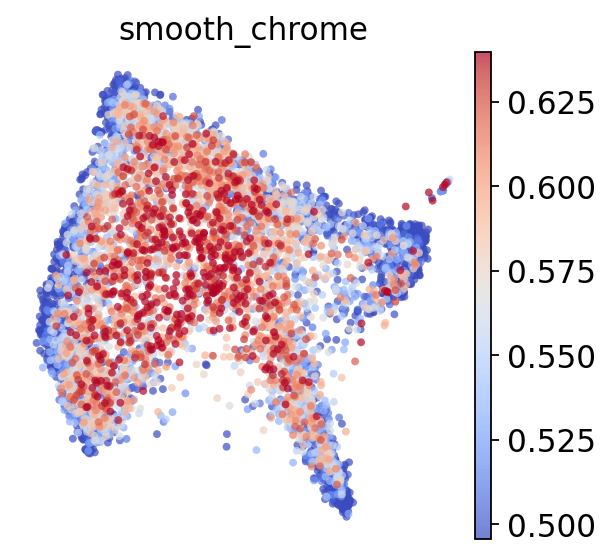

In [19]:
potential = compute_chrom_potential(latent_acc, latent_expr, kernel_function=linear_kernel, gamma=0.1)
smoothed =  smooth_potential_knn(potential, adata_mvi, n=5)
adata_mvi.obs["smooth_chrome"] = smoothed
sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.7, add_outline=False,
        outline_width=(0.1,0), color=["smooth_chrome"],  
           color_map = 'coolwarm', vmax="p95", vmin="p25", save="chrom_potential.pdf") 